In [1]:
import os
import pandas as pd
import numpy as np
import random

import zipfile
from urllib import request

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torchvision import transforms

In [2]:
class NeuMF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, nums_hiddens,
                **kwargs):
        super(NeuMF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors) # GMF의 user
        self.Q = nn.Embedding(num_items, num_factors) # GMF의 item
        self.U = nn.Embedding(num_users, num_factors) # MLP의 user
        self.V = nn.Embedding(num_items, num_factors) # MLP의 item
        layers = []
        before_layer = num_factors*2
        for num_hiddens in nums_hiddens: 
            layers.append(nn.Linear(before_layer, num_hiddens, bias=True))
            layers.append(nn.ReLU())
            before_layer = num_hiddens
        self.mlp = nn.Sequential(*layers)
        self.prediction_layer = nn.Linear(before_layer*2, 1, bias=False)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id) # [2, 1, 10] (batch, 1, 10) 사이즈
        mlp = self.mlp(torch.cat((torch.squeeze(p_mlp, 1) , torch.squeeze(p_mlp, 1)), dim=1)) # (batch size, 20) -> (batch_size, 10)
        con_res = torch.cat((torch.squeeze(gmf), mlp), dim=1)
        pred = self.prediction_layer(con_res)
        return nn.Sigmoid()(pred) # sigmoid node는 1, 0~1사이의 값


In [3]:
class PRDataset(Dataset):
    """
    user id, 구매한 item id, 구매하지않은 item id
    """
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)]) 

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        # 해당 인덱스의 고객이 구매한 아이템을 제외한 전체 아이템
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

In [4]:
def download_ml100k():
    # download
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    savename = "ml-100k.zip"
    request.urlretrieve(url, savename)
    print('Complete!')
    # unzip
    file_name = os.path.join('./', savename)
    file_zip = zipfile.ZipFile(file_name)
    file_zip.extractall('./')
    file_zip.close()

def read_data_ml100k():
    """
    데이터를 다운받고, dataframe형태의 data, user id목록, itme id 목록 반환
    """
    if not os.path.isfile(os.path.join('./ml-100k/', 'u.data')):
        print('Download ...')
        download_ml100k()
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join('./ml-100k/', 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [5]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    """
    과정은 정확히 이해안되는데 user id, item id, score, 유저-아이템 행렬 반환
    explicit 일때는 유저 아이템 행렬
    implicit 일때는 key : 유저, val : 아이템 리스트 인 dict 
    """
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [6]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [44]:
batch_size = 1024
df, num_users, num_items = read_data_ml100k()
train_data, test_data = split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_candidates = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")


train_iter = DataLoader(
    PRDataset(users_train, items_train, candidates, num_items), batch_size=batch_size)

test_iter = DataLoader(
    PRDataset(users_test, items_test, test_candidates, num_items), batch_size=batch_size)

C:\Users\jiwoo\AppData\Local\Temp\ipykernel_3476\1216354282.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df, num_users, num_items = read_data_ml100k()


In [45]:
batch = next(iter(train_iter)) # user, pos, neg
print(len(batch))

3


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuMF(num_factors=10, num_users=num_users, num_items=num_items, nums_hiddens=[10, 10, 10])
model = model.to(device)

In [48]:
class BPRLoss(nn.Module):
    def __init__(self, **kwargs):
        super(BPRLoss, self).__init__(**kwargs)
        self.sigmoid = nn.Sigmoid()

    def forward(self, positive, negative):
        distances = positive - negative
        loss = - torch.sum(torch.log(self.sigmoid(distances)))
        return loss

In [49]:
lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'

loss_func = BPRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

In [50]:
from tqdm import tqdm
import glob
import os

train_epoch_loss = []
val_epoch_loss_lst = []
best_val_epoch_loss = int(1e9)
for epoch in tqdm(range(num_epochs)):
    train_iter_loss = []
    for i, values in enumerate(train_iter):
        p_pos = model(values[0].to(device), values[1].to(device)) 
        p_neg = model(values[0].to(device), values[2].to(device)) 
        loss = loss_func(p_pos, p_neg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_iter_loss.append(loss.detach().item())
        if i%50 == 0:
            print(f'{epoch} epoch {i}th train iter loss: {loss.detach().item()}')  
    train_epoch_loss.append(np.mean(train_iter_loss))
    print(f'{epoch} epoch ALL LOSS : ', np.mean(train_iter_loss))

    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        for i, values in enumerate(test_iter):
            p_pos = model(values[0].to(device), values[1].to(device)) 
            p_neg = model(values[0].to(device), values[2].to(device)) 
            loss = loss_func(p_pos, p_neg)
            val_epoch_loss += loss.detach().item()
        val_epoch_loss /= len(test_iter)
        val_epoch_loss_lst.append(val_epoch_loss)

    if val_epoch_loss < best_val_epoch_loss:
        best_val_epoch_loss = val_epoch_loss
        print(f'New best model loss: {best_val_epoch_loss}')
        if not os.path.exists('ncf_model'):
            os.mkdir('ncf_model')

        if os.path.exists('ncf_model/best.pth'):
            os.remove('ncf_model/best.pth')
            torch.save(model.state_dict(), 'ncf_model/best.pth')
            print('best model is saved!')

    

  0%|          | 0/10 [00:00<?, ?it/s]

0 epoch 0th train iter loss: 714.7183227539062
0 epoch 50th train iter loss: 709.9032592773438


 10%|█         | 1/10 [00:04<00:41,  4.58s/it]

0 epoch ALL LOSS :  708.36642927976
New best model loss: 653.52587890625
1 epoch 0th train iter loss: 709.9814453125
1 epoch 50th train iter loss: 709.5103759765625


 20%|██        | 2/10 [00:09<00:37,  4.72s/it]

1 epoch ALL LOSS :  707.7299899071762
New best model loss: 653.3294067382812
2 epoch 0th train iter loss: 709.955078125
2 epoch 50th train iter loss: 708.8931884765625


 30%|███       | 3/10 [00:14<00:33,  4.79s/it]

2 epoch ALL LOSS :  705.473836053278
New best model loss: 651.0391845703125
3 epoch 0th train iter loss: 706.0966796875
3 epoch 50th train iter loss: 687.4312744140625


 40%|████      | 4/10 [00:18<00:28,  4.70s/it]

3 epoch ALL LOSS :  678.9842302774646
New best model loss: 613.6728515625
4 epoch 0th train iter loss: 667.6949462890625
4 epoch 50th train iter loss: 626.11181640625


 50%|█████     | 5/10 [00:23<00:23,  4.65s/it]

4 epoch ALL LOSS :  609.1841053127014
New best model loss: 575.6744384765625
5 epoch 0th train iter loss: 605.0701904296875
5 epoch 50th train iter loss: 542.4965209960938


 60%|██████    | 6/10 [00:27<00:18,  4.58s/it]

5 epoch ALL LOSS :  552.1774619190963
New best model loss: 547.4964599609375
6 epoch 0th train iter loss: 552.2630615234375
6 epoch 50th train iter loss: 514.5670776367188


 70%|███████   | 7/10 [00:32<00:13,  4.57s/it]

6 epoch ALL LOSS :  521.5444250991663
New best model loss: 530.1261596679688
7 epoch 0th train iter loss: 515.9246826171875
7 epoch 50th train iter loss: 494.45294189453125


 80%|████████  | 8/10 [00:36<00:09,  4.52s/it]

7 epoch ALL LOSS :  501.16792722092464
8 epoch 0th train iter loss: 489.92584228515625
8 epoch 50th train iter loss: 486.043701171875


 90%|█████████ | 9/10 [00:41<00:04,  4.50s/it]

8 epoch ALL LOSS :  488.73514895095036
New best model loss: 521.4351806640625
9 epoch 0th train iter loss: 480.5716857910156
9 epoch 50th train iter loss: 493.1099853515625


100%|██████████| 10/10 [00:45<00:00,  4.57s/it]

9 epoch ALL LOSS :  479.0600633129631
New best model loss: 518.424560546875


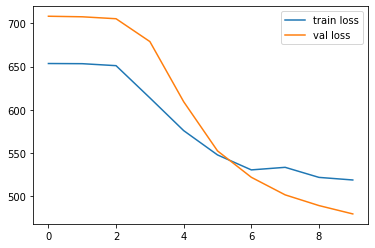

In [51]:
import matplotlib.pyplot as plt

plt.plot(val_epoch_loss_lst, label='train loss')

plt.plot(train_epoch_loss, label='val loss')
plt.legend()